In [2]:
#Load necessary modules
import os
#Some hacks to get around a Basemap issue
os.environ["PYTHONWARNINGS"]="ignore::yaml.YAMLLoadWarning"
import glob
import numpy as np
import xarray as xa
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import nc_time_axis
import cftime
import scipy

dats_mod=["CFSR","ERA","MERRA","JRA"]
base_dir="/global/cscratch1/sd/marielp"


In [3]:
#Examine the averages
flist=[]


for d in dats_mod:
    f="{:}/{:}/{:}_1980_2005_avg.nc".format(base_dir,d,d)
    flist.append(f)


darr_list=[]
for f in flist:
    fopen=xa.open_dataset(f,decode_times=False)
    darr_list.append(fopen)

In [16]:
#initialize a dataset for the model average
#Make a model average
new_lons = np.arange(0.,360.)
new_lats=np.arange(-90.,91.)


model_avg=xa.Dataset(coords={"lat":new_lats,"lon":new_lons})

In [4]:
def daynum_to_date(nday,strcalendar):
    if (strcalendar=="360_day"):
        mn=int(nday/30)
        dn=nday%30
        if (dn==0):
            return(mn,30)
        else:
            return(mn+1,dn)
    else:
        num_days=[31,28,31,30,31,30,31,31,30,31,30,31]
        d_copy= nday
        for m in range(0,len(num_days)):
            dprev=d_copy
            d_copy=d_copy-num_days[m]
            if (d_copy<0):
                break
        return(m+1,dprev)   
    

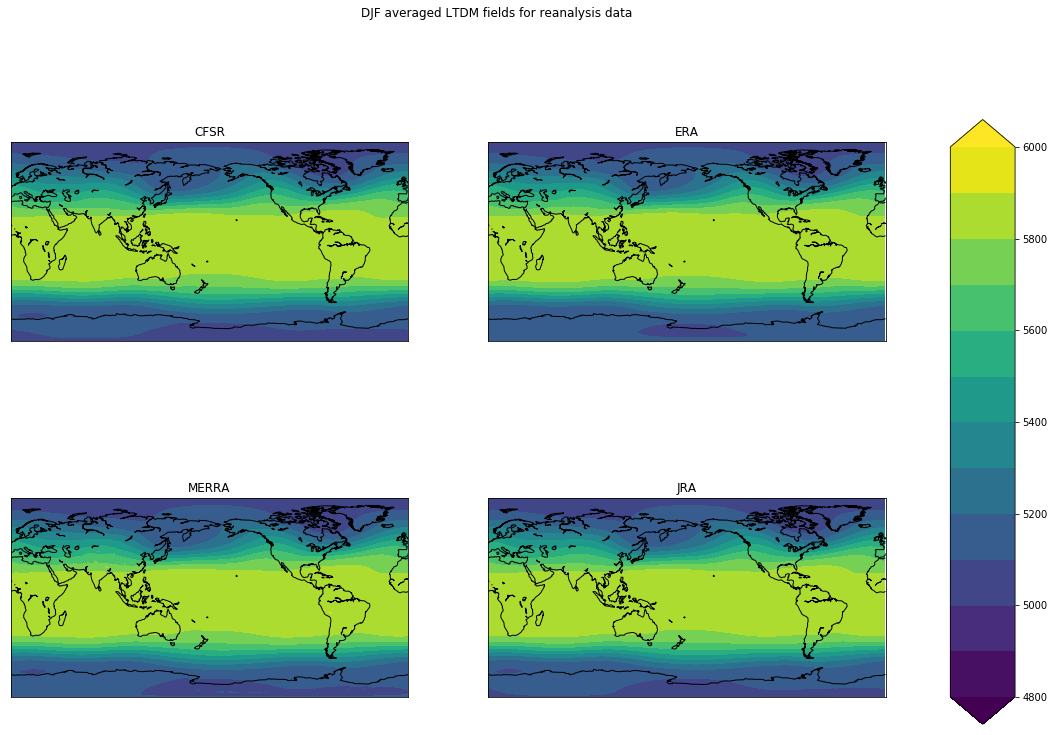

In [5]:
#Now we'll make plots of the averaged values
dc=0
num_files=len(flist)
num_days=[31,28,31,30,31,30,31,31,30,31,30,31]
c_breaks=np.arange(4800,6100,100)

fig, ax = plt.subplots(2,2,sharex="col",sharey="row",figsize=(18,12))
fig.suptitle("DJF averaged LTDM fields for reanalysis data")
num_dats = len(darr_list)
model_avg['modelAvgMean'] = xa.DataArray(np.zeros((len(new_lats),len(new_lons))),dims=["lat","lon"])
for i in range(2):
    for j in range(2):
        d_curr=darr_list[dc]
        t_attrs=d_curr['time'].attrs
        tlen=len(d_curr['time'])
        if 'calendar' not in d_curr['time'].attrs:
            str_cal="noleap"
        else:
            str_cal=d_curr['time'].calendar
        if (str_cal=="360_day"):
            end_ind=30*2
            start_ind=30*11
        else:
            end_ind=31+28+1
            start_ind=365-31
        dnum_start=d_curr['time'][start_ind].values
        dnum_end=d_curr['time'][end_ind].values
        drange=list(range(start_ind,tlen))+list(range(0,end_ind))
        v_mean=d_curr['AZ500'][drange,:,:].mean(dim='time')
        v_mean_interp = v_mean.interp(lat=new_lats,lon=new_lons).fillna(0)
        model_avg['modelAvgMean']+=(v_mean_interp.values/4.)
        m=Basemap(lon_0=180,ax=ax[i,j])
        m.drawcoastlines()
        ax[i,j].set_title("{:}".format(dats_mod[dc]))
        im=ax[i,j].contourf(d_curr.lon.values,d_curr.lat.values,
                         v_mean.values,c_breaks,extend='both')
        dc+=1
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

These are the DJF averages for the LTDM field of the four reanalyses. 

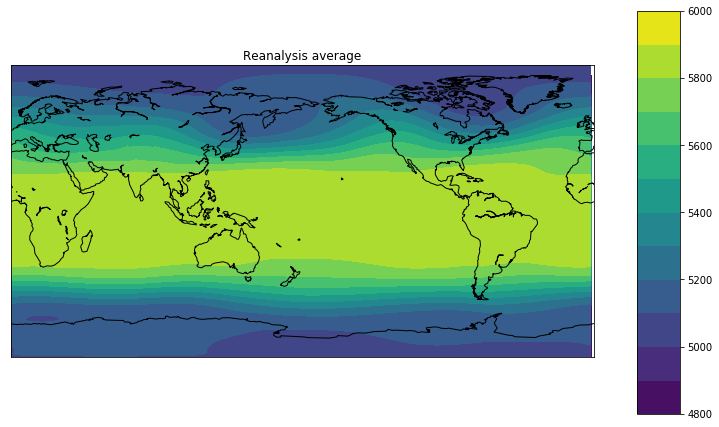

In [7]:
#The Model average of the averaged field
fig,ax= plt.subplots(1,1,figsize=(12,8))
m=Basemap(lon_0=180)
m.drawcoastlines()
ax.set_title("Reanalysis average")
im = ax.contourf(model_avg.lon.values,model_avg.lat.values,model_avg.modelAvgMean.values,c_breaks)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

This is the multi-model average (note that the longitude axis edges do not quite match up due to edge interpolation issues-- I'm trying to figure out if there's a way to do a periodic interpolation)

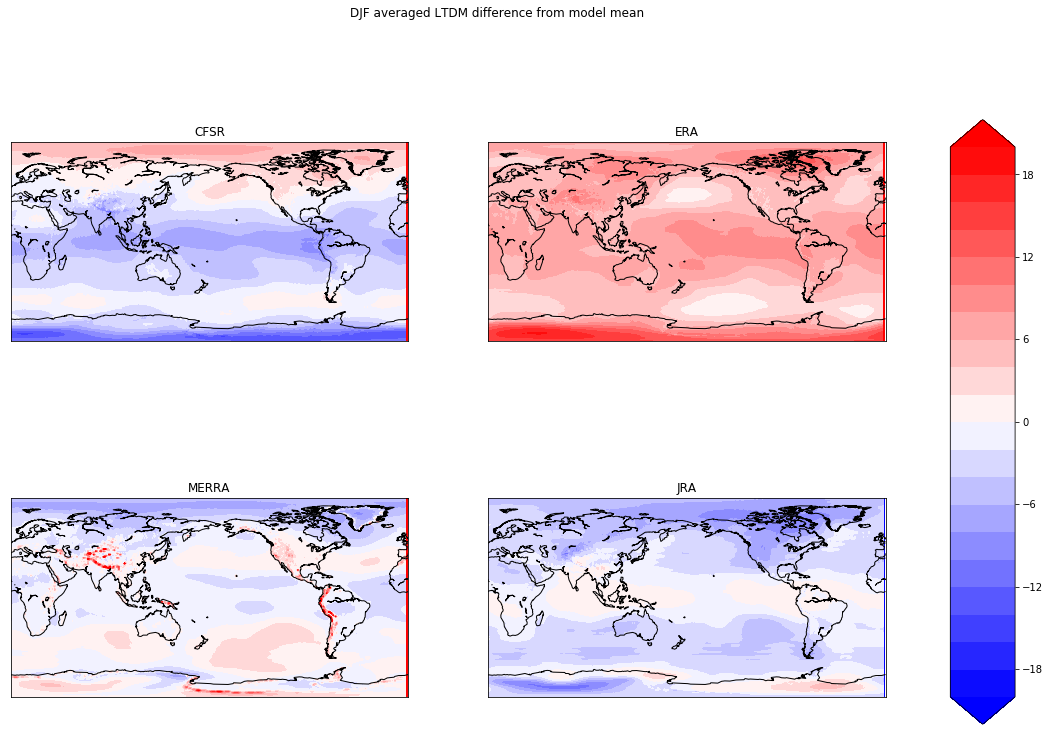

In [8]:
#The deviation from the model average
dc=0
num_days=[31,28,31,30,31,30,31,31,30,31,30,31]
diff_breaks=np.arange(-20,22,2)

fig, ax = plt.subplots(2,2,sharex="col",sharey="row",figsize=(18,12))
fig.suptitle("DJF averaged LTDM difference from model mean")

for i in range(2):
    for j in range(2):
        d_curr=darr_list[dc]
        t_attrs=d_curr['time'].attrs
        tlen=len(d_curr['time'])
        if 'calendar' not in d_curr['time'].attrs:
            str_cal="noleap"
        else:
            str_cal=d_curr['time'].calendar
        if (str_cal=="360_day"):
            end_ind=30*2
            start_ind=30*11
        else:
            end_ind=31+28+1
            start_ind=365-31
        dnum_start=d_curr['time'][start_ind].values
        dnum_end=d_curr['time'][end_ind].values
        drange=list(range(start_ind,tlen))+list(range(0,end_ind))
        v_mean=d_curr['AZ500'][drange,:,:].mean(dim='time')
        v_mean_interp = v_mean.interp(lat=new_lats,lon=new_lons).fillna(0)
        v_diff = v_mean_interp - model_avg['modelAvgMean'].values
        m=Basemap(lon_0=180,ax=ax[i,j])
        m.drawcoastlines()
        ax[i,j].set_title("{:}".format(dats_mod[dc]))
        im=ax[i,j].contourf(model_avg.lon.values,model_avg.lat.values,
                         v_diff.values,diff_breaks,extend="both",cmap="bwr")
        dc+=1
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

These are the individual differences from the multi-model mean. This is rather interesting-- ERA has consistently higher and JRA has consistently lower Z500 average values in the areas we're interested in, although the magnitude of these differences is an order of magnitude smaller than the minimum threshold value so I'm not overly concerned. 

In [10]:
#Plots of the threshold figures for DJF
flist=[]
for d in dats_mod:
    f="{:}/{:}/{:}_1980_2005_thresh.nc".format(base_dir,d,d)
    flist.append(f)

tarr_list=[]
for f in flist:
    fopen=xa.open_dataset(f,decode_times=False)
    tarr_list.append(fopen)

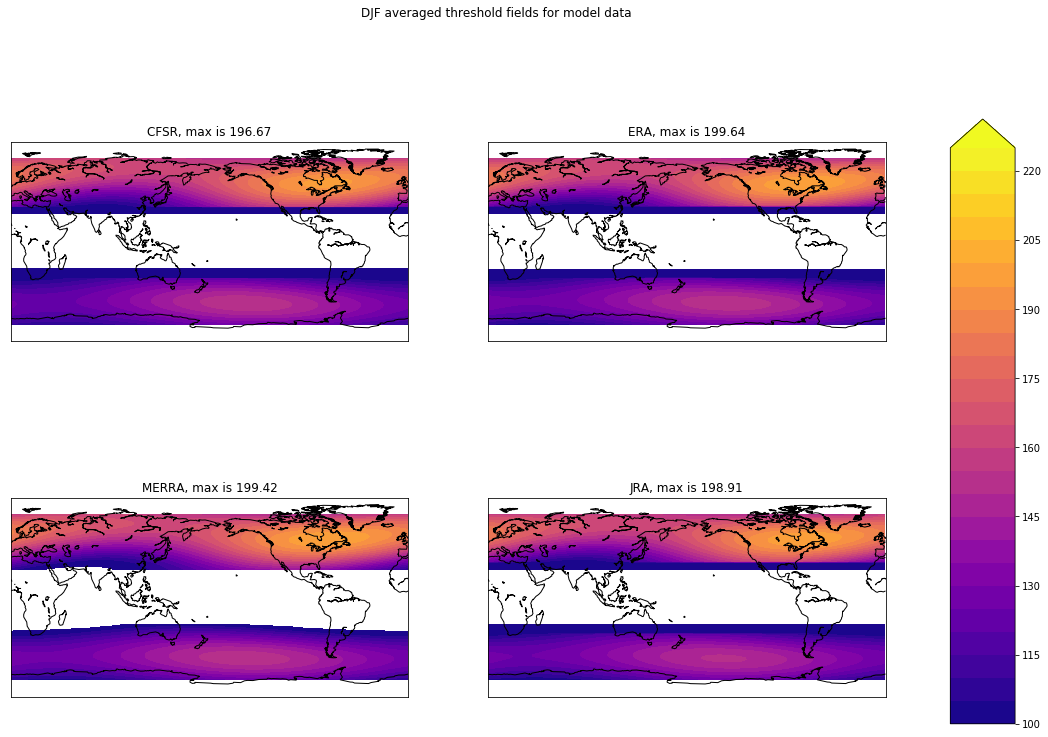

In [11]:
#Now we'll make plots of the averaged values
dc=0
num_files=len(flist)
num_days=[31,28,31,30,31,30,31,31,30,31,30,31]
t_breaks=np.arange(100,230,5)

fig, ax = plt.subplots(2,2,sharex="col",sharey="row",figsize=(18,12))
fig.suptitle("DJF averaged threshold fields for model data")
model_avg['modelThreshMean'] = xa.DataArray(np.zeros((len(new_lats),len(new_lons))),dims=["lat","lon"])

for i in range(2):
    for j in range(2):
        d_curr=tarr_list[dc]
        t_attrs=d_curr['time'].attrs
        tlen=len(d_curr['time'])
        if 'calendar' not in d_curr['time'].attrs:
            str_cal="noleap"
        else:
            str_cal=d_curr['time'].calendar
        if (str_cal=="360_day"):
            end_ind=30*2
            start_ind=30*11
        else:
            end_ind=31+28+1
            start_ind=365-31
        dnum_start=d_curr['time'][start_ind].values
        dnum_end=d_curr['time'][end_ind].values
        drange=list(range(start_ind,tlen))+list(range(0,end_ind))

        v_mean=d_curr['THRESHOLD_DFT'][drange,:,:].mean(dim='time') 
        v_mean[np.where(v_mean<100)]=100.01
        vmax=v_mean.max().values
        v_mean_nh=v_mean.sel(lat=slice(25,75))
        v_mean_sh=v_mean.sel(lat=slice(-75,-25))
        v_mean_0 = v_mean.sel(lat=slice(-24.9,24.9))
        v_mean_0.values = np.zeros(v_mean_0.shape)
        v_mean_rev = xa.concat([v_mean_sh,v_mean_0,v_mean_nh],dim='lat')
        v_mean_rev_interp = v_mean.interp(lat=new_lats,lon=new_lons).fillna(0)
        model_avg['modelThreshMean']+=(v_mean_rev_interp.values/4.)
        m=Basemap(lon_0=180,ax=ax[i,j])
        m.drawcoastlines()
        ax[i,j].set_title("{:}, max is {:.2f}".format(dats_mod[dc],vmax))
        im=ax[i,j].contourf(v_mean_rev.lon.values,v_mean_rev.lat.values,
                         v_mean_rev.values,t_breaks,extend='max',cmap="plasma")
        
        dc+=1
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

These are the DJF-averaged thresholds for the models.

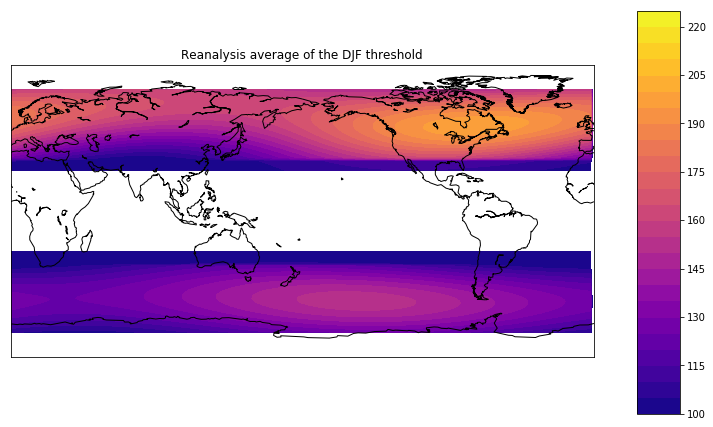

In [13]:

#The Model average of the averaged field
fig,ax= plt.subplots(1,1,figsize=(12,8))
m=Basemap(lon_0=180)
m.drawcoastlines()
ax.set_title("Reanalysis average of the DJF threshold")
model_thresh=model_avg.modelThreshMean
v_mean_nh=model_thresh.sel(lat=slice(25,75))
v_mean_sh=model_thresh.sel(lat=slice(-75,-25))
v_mean_0 = model_thresh.sel(lat=slice(-24.9,24.9))
v_mean_0.values = np.zeros(v_mean_0.shape)
v_mean_rev = xa.concat([v_mean_sh,v_mean_0,v_mean_nh],dim='lat')
im = ax.contourf(v_mean_rev.lon.values,v_mean_rev.lat.values,v_mean_rev.values,t_breaks,cmap="plasma")
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

This the multi-model average for the threshold. The averaged pattern looks very similar to the one seen in the paper, which is rather unsurprising, but some, like NorESM1-M and MPI-ESM-MR have a pattern max that extends out into the Pacific. 

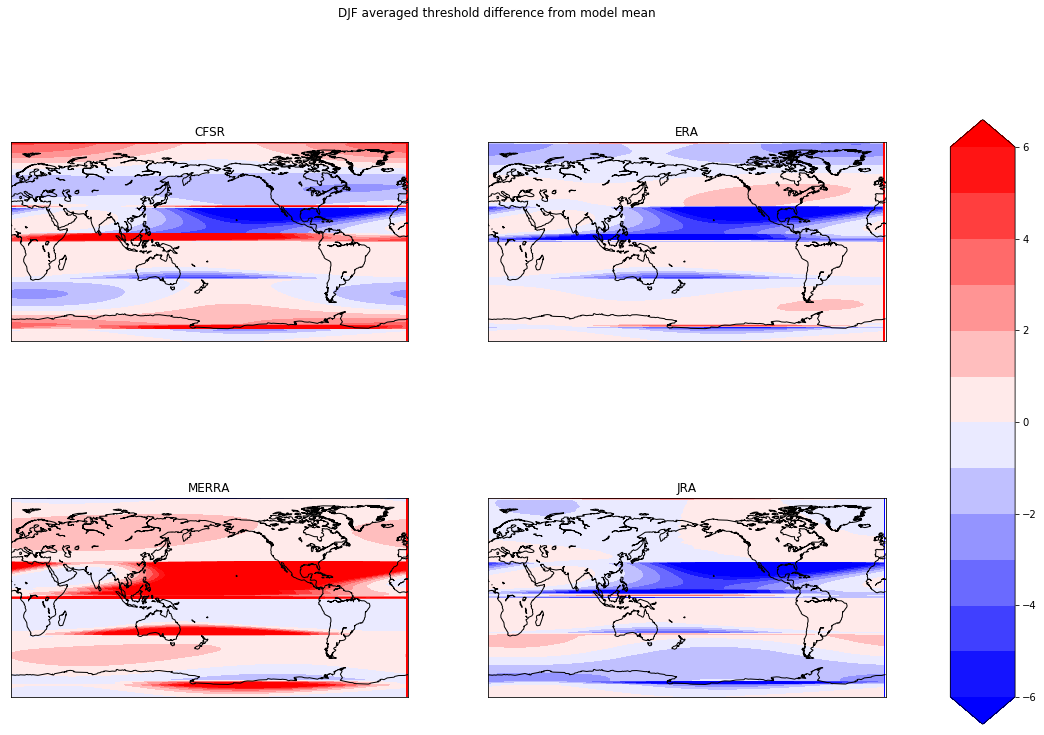

In [15]:
#difference plot for threshold values
dc=0
num_files=len(flist)
num_days=[31,28,31,30,31,30,31,31,30,31,30,31]
dt_breaks=np.arange(-6,7,1)

fig, ax = plt.subplots(2,2,sharex="col",sharey="row",figsize=(18,12))
fig.suptitle("DJF averaged threshold difference from model mean")

for i in range(2):
    for j in range(2):
        d_curr=tarr_list[dc]
        t_attrs=d_curr['time'].attrs
        tlen=len(d_curr['time'])
        if 'calendar' not in d_curr['time'].attrs:
            str_cal="noleap"
        else:
            str_cal=d_curr['time'].calendar
        if (str_cal=="360_day"):
            end_ind=30*2
            start_ind=30*11
        else:
            end_ind=31+28+1
            start_ind=365-31
        dnum_start=d_curr['time'][start_ind].values
        dnum_end=d_curr['time'][end_ind].values
        drange=list(range(start_ind,tlen))+list(range(0,end_ind))

        v_mean=d_curr['THRESHOLD_DFT'][drange,:,:].mean(dim='time') 
        v_mean[np.where(v_mean<100)]=100.01
        v_mean_interp = v_mean.interp(lat=new_lats,lon=new_lons).fillna(0)
        v_diff = v_mean_interp-model_avg['modelThreshMean']
        v_mean_nh=v_diff.sel(lat=slice(26,75))
        v_mean_sh=v_diff.sel(lat=slice(-75,-24))
        v_mean_0 = v_diff.sel(lat=slice(-25,25))
        v_mean_0.values = np.zeros(v_mean_0.shape)
        v_mean_rev = xa.concat([v_mean_sh,v_mean_0,v_mean_nh],dim='lat')
        m=Basemap(lon_0=180,ax=ax[i,j])
        m.drawcoastlines()
        ax[i,j].set_title("{:}".format(dats_mod[dc]))
        im=ax[i,j].contourf(v_diff.lon.values,v_diff.lat.values,
                         v_diff.values,dt_breaks,extend='both',cmap="bwr")
        
        dc+=1
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

These are the threshold differences from the model mean threshold. Again, a very small difference in terms of the magnitude (less than 10 m in most instances!) which is promising. Red/blue lines due to interpolation. 

In [17]:
#Examine the blocking frequency
flist_blobs={}
for d in dats_mod:
    f_glob=sorted(glob.glob("{:}/{:}/BLOBS_NOREGIONAL/{:}*_DJF_blobs_noregional.nc".format(base_dir,d,d)))
    flist_blobs[d] = f_glob
                  


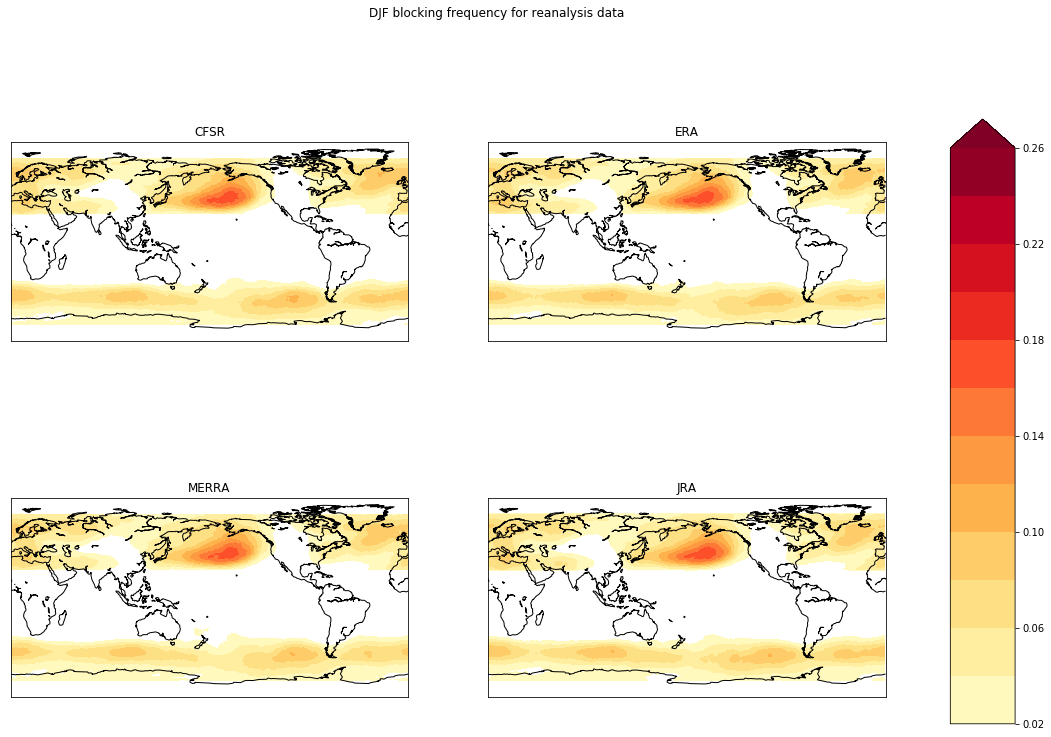

In [18]:
#Now we're plotting the blocking frequency
dc=0
b_breaks=np.arange(0.02,0.28,0.02)
model_avg['modelBlockMean'] = xa.DataArray(np.zeros((len(new_lats),len(new_lons))),dims=["lat","lon"])
fig, ax = plt.subplots(2,2,sharex="col",sharey="row",figsize=(18,12))
fig.suptitle("DJF blocking frequency for reanalysis data")
for i in range(2):
    for j in range(2):
        dcurr=flist_blobs[dats_mod[dc]]
        d_mf = xa.open_mfdataset(dcurr)
        b_avg = d_mf['Z_BLOB'].mean(dim='time')
        b_avg_interp = b_avg.interp(lat=new_lats,lon=new_lons).fillna(0)
        model_avg['modelBlockMean']+=(b_avg_interp.values/4.)
        m=Basemap(lon_0=180,ax=ax[i,j])
        m.drawcoastlines()
        ax[i,j].set_title("{:}".format(dats_mod[dc]))
        im=ax[i,j].contourf(b_avg.lon.values,b_avg.lat.values,
                         b_avg.values,b_breaks,extend='max',cmap="YlOrRd")
        
        dc+=1
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

Blocking frequency for DJF reanalysis models.

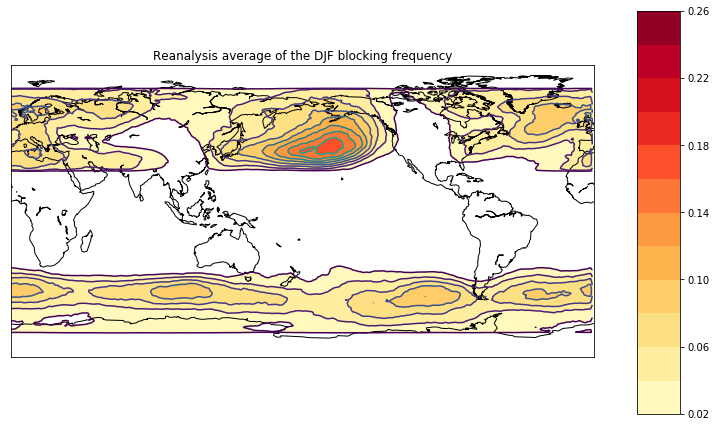

In [19]:

#The Model average of the averaged field
fig,ax= plt.subplots(1,1,figsize=(12,8))
m=Basemap(lon_0=180)
m.drawcoastlines()
ax.set_title("Reanalysis average of the DJF blocking frequency")
im = ax.contourf(model_avg.lon.values,model_avg.lat.values,model_avg.modelBlockMean.values,b_breaks,cmap="YlOrRd")
ax.contour(model_avg.lon.values,model_avg.lat.values,model_avg.modelBlockMean.values,b_breaks)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

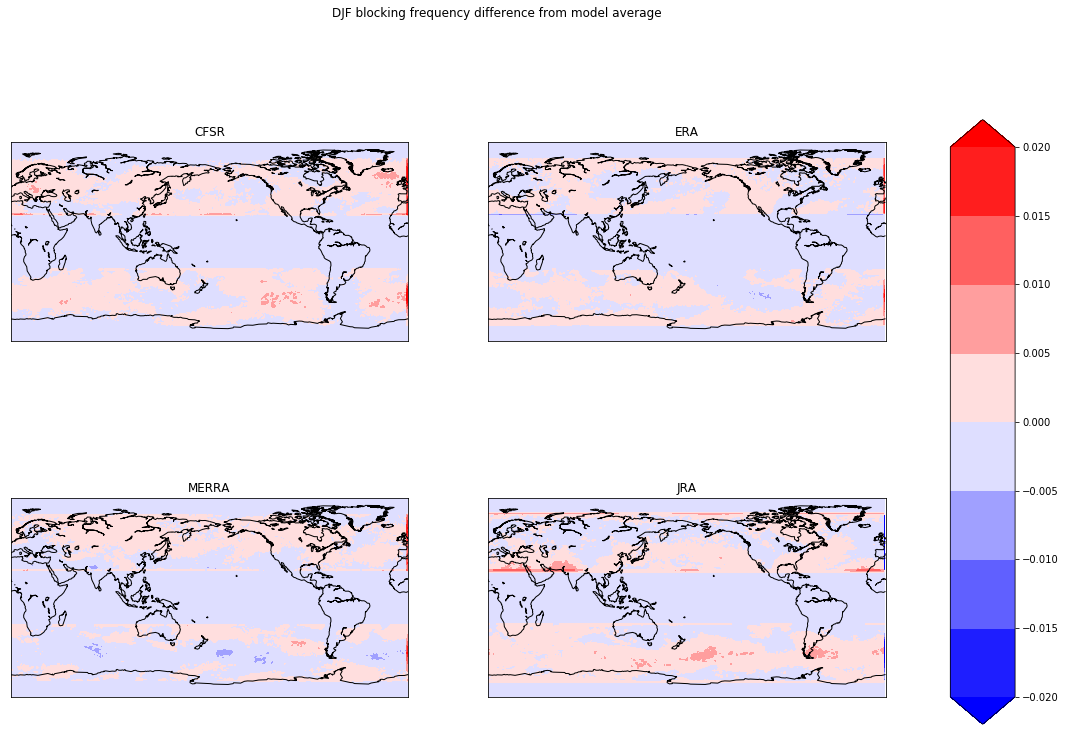

In [20]:
#Now we're plotting the blocking frequency
dc=0
bd_breaks=np.arange(-0.02,0.025,0.005)
fig, ax = plt.subplots(2,2,sharex="col",sharey="row",figsize=(18,12))
fig.suptitle("DJF blocking frequency difference from model average")
for i in range(2):
    for j in range(2):
        dcurr=flist_blobs[dats_mod[dc]]
        d_mf = xa.open_mfdataset(dcurr)
        b_avg = d_mf['Z_BLOB'].mean(dim='time')
        b_avg_interp = b_avg.interp(lat=new_lats,lon=new_lons).fillna(0)
        b_diff = b_avg_interp-model_avg.modelBlockMean.values
        m=Basemap(lon_0=180,ax=ax[i,j])
        m.drawcoastlines()
        ax[i,j].set_title("{:}".format(dats_mod[dc]))
        im=ax[i,j].contourf(model_avg.lon.values,model_avg.lat.values,
                         b_diff.values,bd_breaks,extend='both',cmap="bwr")
        
        dc+=1
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im,cax=cbar_ax)

In terms of the "largest" differences, MERRA2 has more blocking in the NH Pacific, but even these differences cap out at 0.025. I think it's safe to conclude that these reanalysis datasets show good agreement, at least in terms of these particular parameters. Other stats forthcoming.